In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as keras
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Define Functions

In [2]:
def read_data(file):
    """
    Read csv data from the specified file location.
    """
    df = pd.read_csv(file, index_col='Date')
    return df

In [3]:
def clip_recent_days(df, n_days):
    """
    -- optional --
    remove recent days from data frame
    """
    return(df[:-n_days])

In [4]:
def format_predictors_and_targets(df):
    
    """
    params: DataFrame with Predictors and Targets
    
    drop empty rows and prepare targets and predictors
    
    returns: formatted predictors, targets, and number of predictor columns
    
    """
    
    #drop rows with missing values
    df = df.dropna()
    
    # Extract Predictors
    predictors = df[['back_5', 'back_4', 'back_3', 'back_2', 'back_1']].values
    assert type(predictors) is np.ndarray
    
    # count number of predictive columns
    n_cols = predictors.shape[1]
    
    # extract target
    targets = df[['Adj Close']].values
    assert type(targets) is np.ndarray
    
    return predictors, targets, n_cols

# Prepare Data

In [5]:
# DEFINE DATA CONSTANTS
TEST_SIZE = 0.05

In [6]:
# specify location of time series data
file_path = '../data/interim/time_series.csv'

In [7]:
# read time series data
time_series_df = read_data(file_path)
time_series_df

,back_5,back_4,back_3,back_2,back_1,Adj Close
Date,,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN,0.014743
1962-01-03,NaN,NaN,NaN,NaN,0.014743,0.002435
1962-01-04,NaN,NaN,NaN,0.014743,0.002435,-0.022141
1962-01-05,NaN,NaN,0.014743,0.002435,-0.022141,-0.002490
1962-01-08,NaN,0.014743,0.002435,-0.022141,-0.002490,-0.002498
...,...,...,...,...,...,...
2020-04-03,0.014775,0.012455,-0.011656,0.073689,-0.029898,0.031629
2020-04-06,0.012455,-0.011656,0.073689,-0.029898,0.031629,0.018848
2020-04-07,-0.011656,0.073689,-0.029898,0.031629,0.018848,0.061366


In [8]:
# Inspect columns missing values
time_series_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14669 entries, 1962-01-02 to 2020-04-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   back_5     14664 non-null  float64
 1   back_4     14665 non-null  float64
 2   back_3     14666 non-null  float64
 3   back_2     14667 non-null  float64
 4   back_1     14668 non-null  float64
 5   Adj Close  14668 non-null  float64
dtypes: float64(6)
memory usage: 802.2+ KB


In [9]:
# extract last row to predict tomorrow's change
tomorrow = time_series_df.iloc[[-1]].fillna(0)

# call function to format predictors and targets
tomorrow, _ , _ = format_predictors_and_targets(tomorrow)
predictors, targets, n_cols = format_predictors_and_targets(time_series_df)


In [10]:
# scale data to range [0,1]

# create scaler objects
X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

# fit respective scalers to data
predictors = X_scaler.fit_transform(predictors)
tomorrow = X_scaler.transform(tomorrow)
targets = y_scaler.fit_transform(targets)


In [11]:
# test for correct scaling
assert min(predictors.flatten()) == 0
assert max(predictors.flatten()) == 1
assert min(targets.flatten()) == 0
assert max(targets.flatten()) == 1

**Important for Time Series Analysis:**

The training set must only contain stock price data for dates prior to all of the test data.

The model will be overly optimistic if it trained on future data and evaluated on previous data.


RESULT: Random split will not work
split needs to be sequential.


[____________ALL_____SEQUENTIAL_______DATA______]


[____________TRAINING    DATA_____],[___________TEST_DATA____]

In [12]:
# split data into training set and testing set
# SHUFFLE = FALSE
X_train, X_test, y_train, y_test = train_test_split(predictors, targets, test_size=TEST_SIZE, shuffle=False, stratify=None, random_state=1)

In [13]:
# test for sequential split
assert np.argwhere(predictors == X_train[-1])[0][0] == (np.argwhere(predictors == X_test[0])[0][0]) -1
assert np.argwhere(predictors == y_train[-1])[0][0] == (np.argwhere(predictors == y_test[0])[0][0]) -1

In [14]:
# how many days of stock data are in the test set?
len(y_test)

734

# Build Model

In [15]:
# re-shape predictors for keras model
tomorrow = np.reshape(tomorrow, (1, 1, tomorrow.shape[1]))
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

assert X_train.shape[1:] == tomorrow.shape[1:]

In [17]:
def build_sequential_LSTM(n_nodes, n_layers, add_dense):
    
    """
    Params: number of nodes in layers, number of LSTM layers, option to add Dense Layer
    
    Build a Sequential keras model with LSTM and optional Dense Layers
    
    Returns: Keras model with LSTM layers with minimum of 2 LSTM layers
    
    """
    
    # create Sequential model object
    model = Sequential()
    
    # add initial LSTM Layer
    model.add(LSTM(n_nodes, return_sequences=True, input_shape=X_train.shape[1:]))
    

    # add specified amount of additional LSTM layers
    for i in range(n_layers-2):
        model.add(LSTM(n_nodes, return_sequences=True))
    
    #return_sequences = False if next layer is not LSTM
    model.add(LSTM(n_nodes, return_sequences=False))
    
    
    if add_dense:
        # add optional Fully Connected Layer
        model.add(Dense(n_nodes, activation='relu'))
        
    # add Dense layer to produce output
    model.add(Dense(1))
    
    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [18]:
# DEFINE MODEL CONSTANTS
N_NODES = 100
N_LAYERS = 4
ADD_DENSE = True

In [19]:
# build Sequential Model
model = build_sequential_LSTM(N_NODES, N_LAYERS, ADD_DENSE)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            42400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 293,801
Trainable params: 293,801
Non-trainable params: 0
________________________________________________

# Fit The Model Exclusively with Training Data.

In [20]:
# DEFINE TRAINING CONSTANTS
EPOCHS = 2

In [21]:
# fit model to training data
model.fit(X_train, y_train, epochs=EPOCHS)

Epoch 1/2
13929/13929 [==============================] - 6s 407us/step - loss: 0.0148
Epoch 2/2
13929/13929 [==============================] - 3s 235us/step - loss: 0.0011


# Save The Model

In [37]:
# save and load model
model.save('../models/keras_lstm.h5')
model = load_model('../models/keras_lstm.h5')

# verify model structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            42400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 293,801
Trainable params: 293,801
Non-trainable params: 0
________________________________________________

# Make predictions and interpret results

In [23]:
# Make Predictions
predictions = model.predict(X_test)
tomorrows_prediction = model.predict(tomorrow)

array([[0.62920696]], dtype=float32)

In [24]:
# inspect range of scaled predictions
print("Original Prediction Range:\t", min(predictions), max(predictions))
print("Expected Range:\t\t\t", min(y_test), max(y_test))

Original Prediction Range:	 [0.58685285] [0.6380191]
Expected Range:			 [0.31631961] [0.89503638]


In [25]:
# revert scaling
tomorrow_unscaled = y_scaler.inverse_transform(tomorrows_prediction)
unscaled_predictions = y_scaler.inverse_transform(predictions)
unscaled_y_test = y_scaler.inverse_transform(y_test)
print("Unscaled Prediction Range:\t", min(unscaled_predictions), max(unscaled_predictions))
print("Expected Range:\t\t\t", min(unscaled_y_test), max(unscaled_y_test))

Unscaled Prediction Range:	 [-0.0136013] [0.00848726]
Expected Range:			 [-0.13039097] [0.11944208]


In [26]:
# apply exponential function
exponential_tomorrow = np.exp(tomorrow_unscaled)
exponential_predictions = np.exp(unscaled_predictions)
exponential_y_test = np.exp(unscaled_y_test)
print("Exponential Prediction Range:\t", min(exponential_predictions), max(exponential_predictions))
print("Exponential Prediction Range:\t", min(exponential_y_test), max(exponential_y_test))

Exponential Prediction Range:	 [0.9864908] [1.0085233]
Exponential Prediction Range:	 [0.87775219] [1.12686797]


# Inspect Quality of Predictions

In [27]:
# Inspect quality of predictions
places = 4
min_pred = round(float(min(exponential_predictions)), places)
max_pred = round(float(max(exponential_predictions)), places)
mean_pred = round(float(np.mean(exponential_predictions)), places)
median_pred = round(float(np.median(exponential_predictions)), places)
percentile = round(np.percentile(exponential_predictions, 1.0), places)*100
print("min pred:\t", min_pred)
print("max pred:\t", max_pred)
print("mean pred:\t", mean_pred)
print("median pred:\t", median_pred)
print("percentile(1.0):", percentile)


is_good_model = min_pred<=1.0 and max_pred>=1.0
assert is_good_model

min pred:	 0.9865
max pred:	 1.0085
mean pred:	 1.0002
median pred:	 1.0005
percentile(1.0): 99.11


# Score Model

In [28]:
def get_accuracy(y, pred):
    
    """
    params: targets from the test set, model predictions
    
    Scores the model's ability to correctly predict the direction of change
    Magnitude of predicted changes is not scored.
    
    returns: model accuracy against the test set
    """
    #scale and shift binary results
    # -1 -> stock went down
    # +1 -> stock increased or stayed the same
    y = ((y>=1)*2)-1
    pred = ((pred>=1)*2)-1
    
    # stocks move in the same direction when a_i*b_i is positive
    accuracy = (np.sum((y*pred)>=0)/len(y))*100
    
    print("Predicting change in stock price with %f%s accuracy" % (accuracy,'%'))
    
    return accuracy

In [29]:
accuracy = get_accuracy(exponential_y_test, exponential_predictions)

Predicting change in stock price with 51.362398% accuracy


# Visualize Predictions

In [38]:
# read data with Adj Close Price
raw_data = pd.read_csv('../data/raw/raw.csv', index_col=['Date'])

In [31]:
# Create DataFrame to hold vizualization data 

# extract 'Adj Close' column
viz_df = raw_data[['Adj Close']]
viz_df.columns = ['price']


# drop rows with missing data
viz_df = viz_df.dropna()

# slice training data
viz_df = viz_df.iloc[len(X_train)+5:-1]


# create dataFrame with prediction data
predictions_df = pd.DataFrame(exponential_predictions)
predictions_df['actual_return'] = exponential_y_test
predictions_df.index = viz_df.index
predictions_df.columns = ['exp_preds', 'actual_return']

# append prediction columns to viz dataFrame
viz_df['exponential_prediction'] = predictions_df.exp_preds
viz_df['actual_return'] = predictions_df.actual_return

# compute predicted price from predicted returns
viz_df['predicted_price'] = viz_df.price * viz_df.exponential_prediction

# compute and color code correctly predicted changes
viz_df['expected_change'] = viz_df.predicted_price - viz_df.price
viz_df['correct_prediction'] = ((viz_df.exponential_prediction>=1.0) * (viz_df.actual_return>=1.0)) + ((viz_df.exponential_prediction<1.0) * (viz_df.actual_return<1.0))
viz_df['color'] = viz_df.correct_prediction.map({True:'green', False:'red'})
viz_df.head()

/home/alhalarewicz/anaconda3/envs/TimeSeries/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/alhalarewicz/anaconda3/envs/TimeSeries/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


,price,exponential_prediction,actual_return,predicted_price,expected_change,correct_prediction,color
Date,,,,,,,
2017-05-10,72.611153,1.000599,1.008546,72.654649,0.043496,True,green
2017-05-11,73.231689,1.001407,0.999274,73.334694,0.103004,False,red
2017-05-12,73.178505,1.001180,1.003028,73.264833,0.086328,True,green
2017-05-15,73.400116,1.000992,0.996981,73.472960,0.072844,False,red
2017-05-16,73.178505,1.001100,0.993216,73.258997,0.080492,False,red
...,...,...,...,...,...,...,...
2020-04-02,40.400002,1.002370,0.970544,40.495754,0.095753,False,red
2020-04-03,39.209999,1.003785,1.032135,39.358395,0.148396,True,green
2020-04-06,40.470001,1.004327,1.019026,40.645132,0.175131,True,green


In [32]:
# slice one month to visualize results
viz_df1 = viz_df.loc['2019-01-01':'2019-01-31']

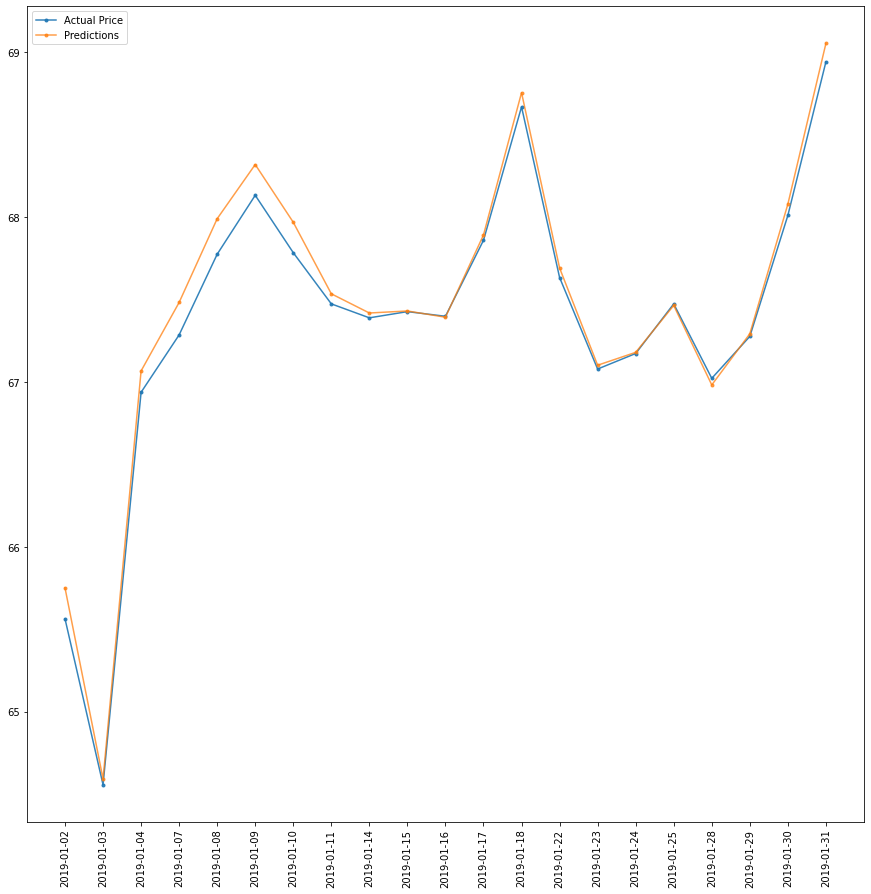

In [33]:
# plot daily predicted prices with actual prices
_ = plt.figure(figsize=(15,15))
_ = plt.plot(viz_df1['price'], marker='.', alpha=0.9)
_ = plt.plot(viz_df1['predicted_price'], marker='.', alpha=0.75)
_ = plt.legend(['Actual Price', 'Predictions'])
_ = plt.xticks(rotation=90)
plt.show()

In [34]:
# create shape and features of predictive arrows
xi = list(viz_df1.index)
yi = [pt for pt in viz_df1['price']]
yf = [pt for pt in viz_df1['predicted_price']]
delta = list(viz_df1.expected_change)
color = list(viz_df1.color)

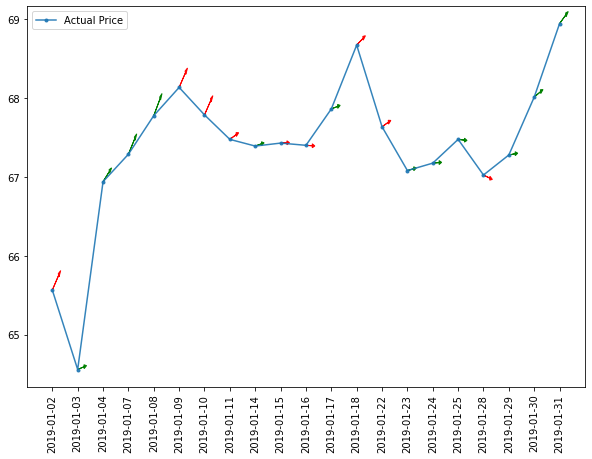

In [35]:
# plot direction and accuracy of predictions with actual price
_ = plt.figure(figsize=(10,7))
_ = plt.plot(viz_df1['price'], marker='.', alpha=0.9)
_ = plt.legend(['Actual Price', 'Predictions'])
_ = plt.xticks(rotation=90)

# create individual arrows for daily predictions
for i in range(len(xi)):
    _ = plt.arrow(xi[i], yi[i],0.25, delta[i], head_width=0.05, head_length=0.1, color=color[i])
plt.show()

# Tomorrow's prediction

In [36]:
def action(x):
    """
    params: expected change in stock price
    
    Map to expected changes in the action column
    
    Return: "Buy" if expected increase, "SELL" if expected decrease
    """
    if x>0:
        return "BUY"
    else:
        return "SELL"
    

# display a dataFrame providing insight to th user
expected_return = float(exponential_tomorrow)
tomorrow_df = raw_data[['Adj Close']].iloc[[-1]]
tomorrow_df.columns = ['price_today']
tomorrow_df['price_tomorrow'] = tomorrow_df['price_today']* expected_return
tomorrow_df['Action'] = (tomorrow_df.price_tomorrow - tomorrow_df.price_today).map(action)
tomorrow_df

,price_today,price_tomorrow,Action
Date,,,
2020-04-09,43.130001,43.332453,BUY
